In [1]:
import sys

sys.path.append("/home/pervinco/SemanticSegmentation")

In [2]:
import os
import cv2
import random
import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from glob import glob
from torch.utils.data import Dataset, DataLoader

from utils.utils import Args
from data.util import mask_encoding, mask_decoding, get_bbox_from_mask
from data.augmentation import basic_transform, mosaic, sep, apply_transform, get_bg_image, mixup

In [3]:
data_dir = "/home/pervinco/Datasets/BKAI_IGH_NeoPolyp"

# 1.Data analysis

In [4]:
image_files = sorted(glob(f"{data_dir}/train/*"))
mask_files = sorted(glob(f"{data_dir}/train_gt/*"))

print(len(image_files), len(mask_files))

1000 1000


/home/pervinco/Datasets/BKAI_IGH_NeoPolyp/train/00fd197cd955fa095f978455cef3593c.jpeg /home/pervinco/Datasets/BKAI_IGH_NeoPolyp/train_gt/00fd197cd955fa095f978455cef3593c.jpeg
(977, 1280, 3) (977, 1280, 3)


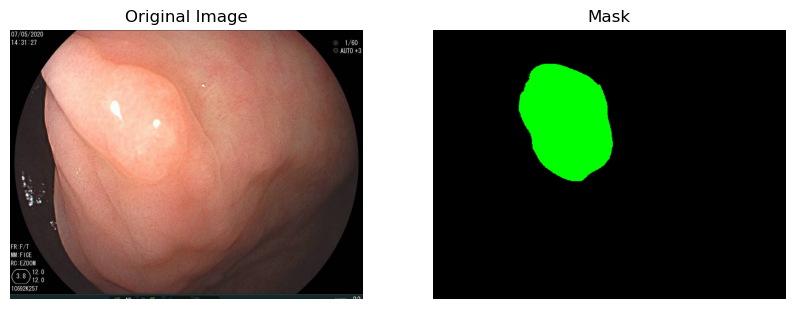

In [5]:
idx = 3
image_file = image_files[idx]
mask_file = mask_files[idx]
print(image_file, mask_file)

image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_file)
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

print(image.shape, mask.shape)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title('Mask')
plt.axis('off')

plt.show()

In [6]:
gray_mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

unique_values = np.unique(gray_mask)
print(f"Unique pixel values in the mask: {unique_values}")

Unique pixel values in the mask: [  0   1   2   3   4   5   6   7 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157]


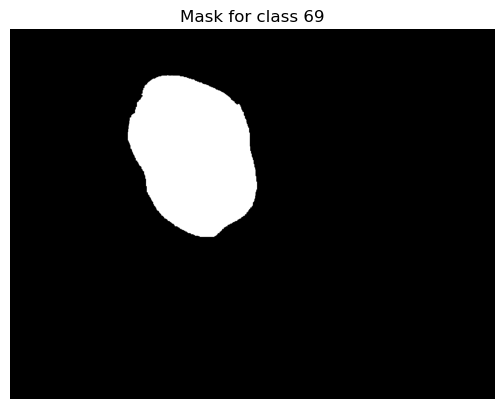

In [7]:
class_value = 69
class_mask = gray_mask >= class_value

plt.imshow(class_mask, cmap='gray')
plt.title(f"Mask for class {class_value}")
plt.axis('off')
plt.show()

위 결과를 봤을 때, [0, 1] 또는 [0, 2]로 구성되지 않고 여러 가지 값들로 구성되어 있음을 볼 수 있다. 결과적으로 마스크 픽셀에 대한 정제가 필요하다.

# 2.Mask Encoding & Decoding

문제를 해결하기 위해 encoding, decoding 함수 정의.

- encoding : HSV 기준 픽셀이 지정된 범위 내에 있는 픽셀인 경우 클래스 1(non-neoplastic polyps), 클래스 2(neoplastic polyps)로 처리. 즉, [0, 1, 2]로 구성되는 binary mask
- decoding : 인코딩된 마스크를 보고 RGB 픽셀로 맵핑.

In [8]:
def mask_encoding(mask, red_threshold=0.6, green_threshold=0.6):
    # Convert BGR mask to HSV
    hsv_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

    # Define thresholds for red and green channels in BGR
    red_lower = np.array([0, 100, 100])
    red_upper = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([179, 255, 255])
    green_lower = np.array([35, 100, 100])
    green_upper = np.array([85, 255, 255])

    # Create masks for red and green colors
    red_mask1 = cv2.inRange(hsv_mask, red_lower, red_upper)
    red_mask2 = cv2.inRange(hsv_mask, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    green_mask = cv2.inRange(hsv_mask, green_lower, green_upper)

    # Initialize full_mask with zeros
    full_mask = np.zeros_like(red_mask)

    # Set red pixels to 1 and green pixels to 2
    full_mask[red_mask > 0] = 2
    full_mask[green_mask > 0] = 1

    return full_mask


def mask_decoding(pred_mask):
    decoded_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    decoded_mask[pred_mask == 0] = [0, 0, 0]
    decoded_mask[pred_mask == 1] = [0, 255, 0] ## Green
    decoded_mask[pred_mask == 2] = [255, 0, 0] ## Red
    
    return decoded_mask

/home/pervinco/Datasets/BKAI_IGH_NeoPolyp/train/00fd197cd955fa095f978455cef3593c.jpeg /home/pervinco/Datasets/BKAI_IGH_NeoPolyp/train_gt/00fd197cd955fa095f978455cef3593c.jpeg
(977, 1280)
[0 1]


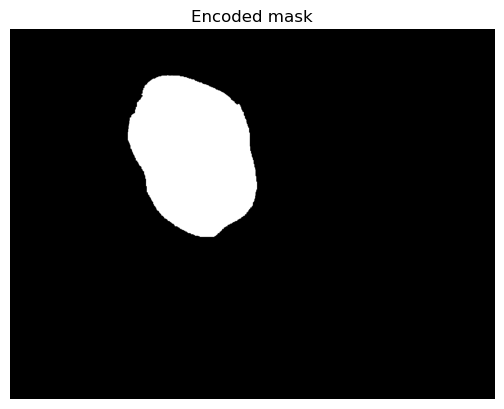

In [9]:
idx = 3
image_file = image_files[idx]
mask_file = mask_files[idx]
print(image_file, mask_file)

image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_file)
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

encoded_mask = mask_encoding(mask)
print(encoded_mask.shape)
print(np.unique(encoded_mask))

plt.imshow(encoded_mask, cmap="gray")
plt.title("Encoded mask")
plt.axis('off')
plt.show()

(977, 1280, 3)
[  0 255]


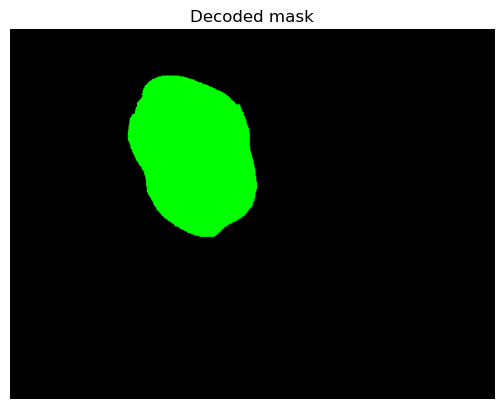

In [10]:
decoded_mask = mask_decoding(encoded_mask)
print(decoded_mask.shape)
print(np.unique(decoded_mask))

plt.imshow(decoded_mask)
plt.title("Decoded mask")
plt.axis('off')
plt.show()

In [11]:
save_dir = f"{data_dir}/train_mask"
os.makedirs(save_dir, exist_ok=True)

for mask_file in mask_files:
    file_name = mask_file.split('/')[-1].split('.')[0]
    mask = cv2.imread(mask_file)
    encoded_mask = mask_encoding(mask)
    decoded_mask = mask_decoding(encoded_mask)
    decoded_mask = cv2.cvtColor(decoded_mask, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{save_dir}/{file_name}.jpeg", decoded_mask)

# 3.Class Distribution

각 클래스의 분포를 확인하기 위해 인코딩 마스크를 기반으로 구분한다.
- 1만 존재하는 마스크.
- 2만 존재하는 마스크.
- 1과 2가 동시에 존재하는 마스크.

In [11]:
def sort_masks(mask_files):
    red_masks = []
    green_masks = []
    red_and_green_masks = []
    
    for mask_file in mask_files:
        file_name = mask_file.split("/")[-1].split(".")[0]
        mask = cv2.imread(mask_file)
        encoded_mask = mask_encoding(mask)
        
        has_green = np.any(encoded_mask == 1)
        has_red = np.any(encoded_mask == 2)
        
        if has_green and not has_red:
            green_masks.append(file_name)
        elif has_red and not has_green:
            red_masks.append(file_name)
        elif has_green and has_red:
            red_and_green_masks.append(file_name)
    
    with open(f'{data_dir}/files/red.txt', 'w') as file:
        for item in red_masks:
            file.write(f"{item}\n")
            
    with open(f'{data_dir}/files/green.txt', 'w') as file:
        for item in green_masks:
            file.write(f"{item}\n")
            
    with open(f'{data_dir}/files/red_and_green.txt', 'w') as file:
        for item in red_and_green_masks:
            file.write(f"{item}\n")
    
    print(len(red_masks), len(green_masks), len(red_and_green_masks))
    labels = ['Red Only', 'Green Only', 'Red and Green']
    counts = [len(red_masks), len(green_masks), len(red_and_green_masks)]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=['red', 'green', 'orange'])
    plt.title('Mask Type Distribution')
    plt.xlabel('Mask Type')
    plt.ylabel('Count')
    plt.xticks(labels)
    plt.show()

693 257 50


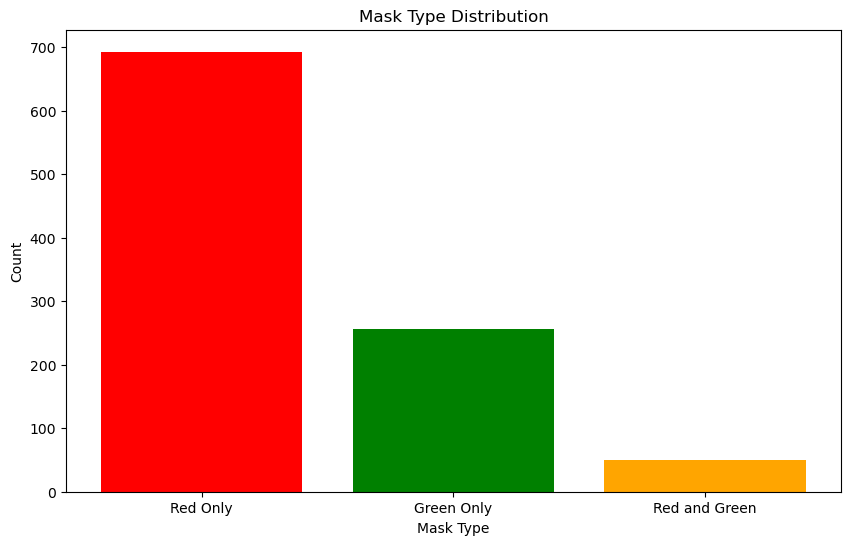

In [12]:
if not os.path.exists(f"{data_dir}/files"):
    os.makedirs(f"{data_dir}/files")
    
sort_masks(mask_files)

# 4. Split Train/Valid set

In [13]:
def read_file_list(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

In [14]:
red_masks = read_file_list(f'{data_dir}/files/red.txt')
green_masks = read_file_list(f'{data_dir}/files/green.txt')
red_and_green_masks = read_file_list(f'{data_dir}/files/red_and_green.txt')

In [15]:
# 클래스 1과 2가 동시에 존재하는 경우 균등 분배
half_red_and_green = int(len(red_and_green_masks) * 0.1)
valid_red_and_green = red_and_green_masks[:half_red_and_green]
train_red_and_green = red_and_green_masks[half_red_and_green:]

# 클래스 1과 클래스 2의 1대1 비율을 유지하기 위한 작업
# 가능한 한 많은 클래스 1 데이터를 유지하기 위해, validation set에 클래스 1 데이터를 먼저 할당
valid_green = green_masks[:len(red_masks)//10]
train_green = green_masks[len(red_masks)//10:]

# 클래스 2 데이터 중 validation set에 할당되지 않은 나머지를 train set에 할당
valid_red = red_masks[:len(valid_green)]  # validation에 할당된 클래스 1 데이터와 같은 양의 클래스 2 데이터를 validation에 할당
train_red = red_masks[len(valid_green):]

# 최종 train set과 validation set 구성
train_files = train_red + train_green + train_red_and_green
valid_files = valid_red + valid_green + valid_red_and_green

# 결과를 파일에 기록
with open(f'{data_dir}/files/train.txt', 'w') as file:
    for item in train_files:
        file.write(f"{item}\n")

with open(f'{data_dir}/files/valid.txt', 'w') as file:
    for item in valid_files:
        file.write(f"{item}\n")

print(f"Train set size: {len(train_files)}, Validation set size: {len(valid_files)}")

Train set size: 857, Validation set size: 143


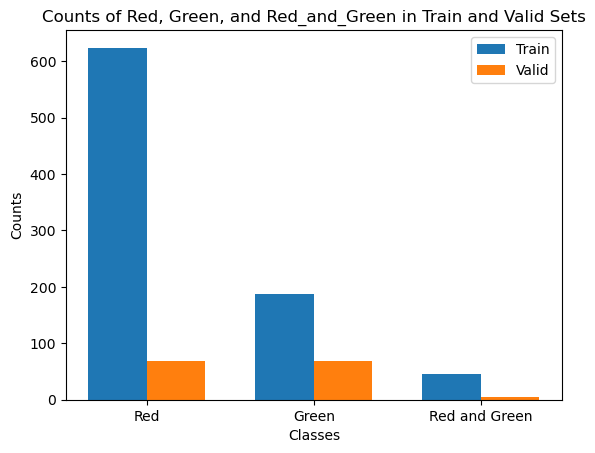

In [16]:
train_counts = {
    'red': len(train_red),
    'green': len(train_green),
    'red_and_green': len(train_red_and_green)
}

valid_counts = {
    'red': len(valid_red),
    'green': len(valid_green),
    'red_and_green': len(valid_red_and_green)
}

labels = ['Red', 'Green', 'Red and Green']
train_values = [train_counts['red'], train_counts['green'], train_counts['red_and_green']]
valid_values = [valid_counts['red'], valid_counts['green'], valid_counts['red_and_green']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
train_bars = ax.bar(x - width/2, train_values, width, label='Train')
valid_bars = ax.bar(x + width/2, valid_values, width, label='Valid')

ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Counts of Red, Green, and Red_and_Green in Train and Valid Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:
# def split_and_save_files(red_masks, green_masks, red_and_green_masks):
#     half_index_red_and_green = len(red_and_green_masks) // 2
#     train_red_and_green = red_and_green_masks[:half_index_red_and_green]
#     valid_red_and_green = red_and_green_masks[half_index_red_and_green:]

#     available_class_2_for_valid = len(green_masks) - (len(red_masks) - len(valid_red_and_green))    
#     valid_class_1_amount = min(len(green_masks) // 4, available_class_2_for_valid)
    
#     valid_green = green_masks[:valid_class_1_amount]
#     train_green = green_masks[valid_class_1_amount:]
    
#     valid_red = red_masks[:valid_class_1_amount + len(valid_red_and_green)]
#     train_red = red_masks[valid_class_1_amount + len(valid_red_and_green):]

#     def save_to_file(file_list, file_name):
#         with open(file_name, 'w') as file:
#             for item in file_list:
#                 file.write(f"{item}\n")

#     save_to_file(train_red, f'{data_dir}/files/train_red.txt')
#     save_to_file(valid_red, f'{data_dir}/files/valid_red.txt')
#     save_to_file(train_green, f'{data_dir}/files/train_green.txt')
#     save_to_file(valid_green, f'{data_dir}/files/valid_green.txt')
#     save_to_file(train_red_and_green, f'{data_dir}/files/train_red_and_green.txt')
#     save_to_file(valid_red_and_green, f'{data_dir}/files/valid_red_and_green.txt')


# split_and_save_files(red_masks, green_masks, red_and_green_masks)

# 5. Dataset Class

In [6]:
if not os.path.exists(os.path.join(data_dir, "train_boxes/train_boxes")):
    os.makedirs(os.path.join(data_dir, "train_boxes/train_boxes"))
if not os.path.exists(os.path.join(data_dir, "train_boxes/samples")):
    os.makedirs(os.path.join(data_dir, "train_boxes/samples"))

for image_file, mask_file in zip(image_files, mask_files):
    file_name = os.path.basename(mask_file).split('.')[0]
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_file)
    encoded_mask = mask_encoding(mask)

    bboxes_dict = get_bbox_from_mask(encoded_mask)
    sample_image = image.copy()  # 이미지 복사본 생성
    for class_id, bboxes in bboxes_dict.items():
        bbox_file_path = os.path.join(data_dir, "train_boxes/train_boxes", f"{file_name}.txt")
        with open(bbox_file_path, "w") as f:
            for bbox in bboxes:
                # 파일에 `class_idx xmin ymin xmax ymax` 형태로 기록
                bbox_str = ' '.join(map(str, [class_id] + list(bbox)))
                f.write(f"{bbox_str}\n")

                # 이미지에 바운딩 박스 그리기
                xmin, ymin, xmax, ymax = bbox
                cv2.rectangle(sample_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # 바운딩 박스가 그려진 이미지를 samples 폴더에 저장
    sample_image_path = os.path.join(data_dir, "train_boxes/samples", f"{file_name}.jpg")
    cv2.imwrite(sample_image_path, sample_image)

In [ ]:
# if not os.path.exists(f"{data_dir}/train_boxes/train_boxes"):
#     os.makedirs(f"{data_dir}/train_boxes/train_boxes")

# for image_file, mask_file in zip(image_files, mask_files):
#     file_name = mask_file.split('/')[-1].split('.')[0]
#     mask = cv2.imread(mask_file)
#     encoded_mask = mask_encoding(mask)

#     bboxes_dict = get_bbox_from_mask(encoded_mask)  # 바운딩 박스 정보가 담긴 딕셔너리
#     print(bboxes_dict)
    
#     # 딕셔너리의 각 값(value)에 해당하는 바운딩 박스 리스트를 순회
#     for class_id, bboxes in bboxes_dict.items():
#         with open(f"{data_dir}/train_boxes/train_boxes/{file_name}_{class_id}.txt", "w") as f:
#             for bbox in bboxes:
#                 bbox_str = ' '.join(map(str, bbox))
#                 f.write(f"{bbox_str}\n")


In [ ]:
class BKAIDataset(Dataset):
    CLASSES = ["background", "non-neoplastic polyps", "neoplastic polyps"]
    COLORMAP = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]

    def __init__(self, args, feature_extractor=None, image_set="train"):
        self.args = args
        self.feature_extractor = feature_extractor
        self.is_train = True if image_set == "train" else False
        
        self.data_dir = args.data_dir
        self.image_dir = f"{self.data_dir}/train/train"
        self.mask_dir = f"{self.data_dir}/train_gt/train_gt"
        self.bbox_dir = f"{self.data_dir}/train_boxes/train_boxes"
        self.transform = basic_transform(is_train=self.is_train, img_size=args.img_size)

        with open(f"{self.data_dir}/files/{image_set}.txt", 'r') as f:
            self.total_files = [line.strip() for line in f.readlines()]

        self.bg_files = glob(f"{self.data_dir}/background/0_normal/*.jpg")

    def __len__(self):
        return len(self.total_files)

    def get_img_mask(self, file_name):
        image_path = f"{self.image_dir}/{file_name}.jpeg"
        mask_path = f"{self.mask_dir}/{file_name}.jpeg"
        bbox_path = f"{self.bbox_dir}/{file_name}.txt"
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        
        labels = []
        bboxes = []
        if os.path.exists(bbox_path):
            with open(bbox_path, 'r') as f:
                for line in f:
                    label, xmin, ymin, xmax, ymax = map(int, line.strip().split())
                    labels.append(label)
                    bboxes.append((xmin, ymin, xmax, ymax))
                    
        return image, mask, bboxes, labels


    def __getitem__(self, idx):
        if self.is_train:
            p = random.random()
            if p < 0.3:
                file_name = self.total_files[idx]
                image, mask, bboxes, labels = self.get_img_mask(file_name)
                batch_image, batch_mask, batch_bboxes, batch_labels = apply_transform(image, mask, bboxes, labels, self.transform)

                if random.random() > 0.7:
                    background_image = get_bg_image(self.bg_files)
                    batch_image = mixup(batch_image, background_image, img_size=self.args.img_size, alpha=random.uniform(self.args.mixup_alpha, self.args.mixup_alpha + 0.3))

            elif 0.3 < p <= 0.6:
                piecies = []
                while len(piecies) < 4:
                    i = random.randint(0, len(self.total_files)-1)
                    file_name = self.total_files[i]
                    image, mask, bboxes, labels = self.get_img_mask(file_name)

                    if random.random() > 0.5:
                        piece_image, piece_mask, batch_bboxes, batch_labels = apply_transform(image, mask, bboxes, labels, self.transform)
                    else:
                        piece_image, piece_mask = sep(image, mask, self.args.img_size, alpha=random.uniform(self.args.spatial_alpha, self.args.spatial_alpha + 0.2))

                    piecies.append([piece_image, piece_mask])

                batch_image, batch_mask = mosaic(piecies, size=self.args.img_size)
                if random.random() > 0.7:
                    background_image = get_bg_image(self.bg_files)
                    piece_image = mixup(batch_image, background_image, img_size=self.args.img_size, alpha=random.uniform(self.args.mixup_alpha, self.args.mixup_alpha + 0.3))

            elif 0.6 < p <= 1:
                file_name = self.total_files[idx]
                image, mask, bboxes, labels = self.get_img_mask(file_name)
                batch_image, batch_mask = sep(image, mask, self.args.img_size, alpha=random.uniform(self.args.spatial_alpha, self.args.spatial_alpha + 0.2))

                if random.random() > 0.7:
                    background_image = get_bg_image(self.bg_files)
                    batch_image = mixup(batch_image, background_image, img_size=self.args.img_size, alpha=random.uniform(self.args.mixup_alpha, self.args.mixup_alpha + 0.3))
                
        else:
            file_name = self.total_files[idx]
            image, mask, bboxes, labels = self.get_img_mask(file_name)
            batch_image, batch_mask, batch_bboxes, batch_labels = apply_transform(image, mask, bboxes, labels, self.transform)

        batch_mask = mask_encoding(batch_mask)
        if self.feature_extractor is not None:
            encoded_inputs = self.feature_extractor(batch_image, batch_mask, return_tensors="pt")
            for k, v in encoded_inputs.items():
                encoded_inputs[k].squeeze_()

            return encoded_inputs   
        
        else:
            return batch_image, batch_mask

In [ ]:
args = Args("/home/pervinco/SemanticSegmentation/config.yaml", is_train=False)
dataset = BKAIDataset(args, image_set="train")

In [ ]:
def visualize_dataset_sample(dataset, idx):
    image, encoded_mask = dataset[idx]
    
    # image = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # image = std * image + mean
    # image = np.clip(image, 0, 1)
    
    decoded_mask = mask_decoding(encoded_mask)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    axes[1].imshow(decoded_mask)
    axes[1].set_title('Decoded Mask')
    axes[1].axis('off')
    
    plt.show()

In [ ]:
visualize_dataset_sample(dataset, idx=1)

In [ ]:
args.num_workers = os.cpu_count()
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(dataset, batch_size=4)

In [ ]:
if not os.path.exists(f"{data_dir}/batch_images"):
    os.makedirs(f"{data_dir}/batch_images")

for i, (images, masks) in enumerate(dataloader):
    print(images.shape, masks.shape)
    if i == 10:
        break
    images, masks = images.numpy(), masks.numpy()
    for j, (image, mask) in enumerate(zip(images, masks)):
        mask = mask_decoding(mask)

        overlay = cv2.addWeighted(image, 0.7, mask, 0.3, 0)
        result = np.hstack((image, mask, overlay))
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        cv2.imwrite(f"{data_dir}/batch_images/batch{i}_no{j}.png", result)